In [14]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore")

import unicodedata

import lightgbm as lgb

In [15]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    filename = "exp012"
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"
    num_cores = 4 # kaggleの方と統一
    categorical_features = [
        "fuel", "title_status", "type", "state", "region", "manufacturer", "condition", "cylinders", "transmission", "drive", "size", "paint_color"
        ]

In [16]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [17]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [18]:
# ===================================================================
#  preprocessing
# ===================================================================
def preprocessing(all_data: pd.DataFrame):
    """
    train, testデータで共通の前処理のコード
    
    ・yearの異常値を直す
    ・manufacturerの表記を統一する
    ・sizeの表記を統一する
    ・regionの欠損値をtrain dataの(state, region)の組み合わせから補完する。残った欠損値は調べて補完する。
    ・title_statusとtypeの欠損値処理はとりあえず放置

    Args:
        all_data (pd.DataFrame): pd.concat([train, test], ignore_index=True)
    """
    # year
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    all_data["year"] = all_data["year"].replace(year_dict)
    
    
    # manufacturer
    all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
    manufacturer_map = {
        'niѕsan':'nissan',
        'nisѕan':'nissan',
        'subαru':'subaru',
        'toyotа':'toyota',
        'sαturn':'saturn',
        'аcura':'acura',
        'vоlkswagen':'volkswagen',
        'lexuѕ':'lexus',
        'ᴄhrysler':'chrysler',
    }
    all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)
    
    
    # size
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    all_data["size"] = all_data["size"].replace(size_dict)
        
    
    # 地域
    ## region -> stateが一意に定まることを確認
    region_state = {region:{} for region in all_data[all_data["flag"]=="train"]['region'].unique()}
    for row, value in all_data[all_data["flag"]=="train"].iterrows():
        if not pd.isna(value['state']):
            if value['state'] not in region_state[value['region']]:
                region_state[value['region']][value['state']] = 1
            else:
                region_state[value['region']][value['state']] += 1
    for region, state_dict in region_state.items():
        if len(state_dict) > 1 or state_dict == {}:
            region_state[region] = pd.NA
        else:
            region_state[region] = list(state_dict.keys())[0]

    ## regionからstateを決定
    all_data['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(all_data['region'], all_data['state'])]
    all_data.loc[all_data["region"] == "northwest KS", "state"] = "ks"
    all_data.loc[all_data["region"] == "ashtabula", "state"] = "oh"
    all_data.loc[all_data["region"] == "southern WV", "state"] = "wv"
    
    # type
    ## 欠損値 train: 456, test: 229
    
    # title_status
    ## 欠損値 train: 456, test: 229
    
    # fuel
    ## 欠損値 train: 1239, test: 1495
    
    all_data["elapsed_years"] = 2023 - all_data["year"]
    all_data["log_elapsed_years"] = np.log(all_data["elapsed_years"])
    all_data["sqrt_elapsed_years"] = np.sqrt(all_data["elapsed_years"])
    
    return all_data
all_data = preprocessing(all_data)

In [19]:
train["price"].quantile(0.9)

26562.500000000007

In [20]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=20, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)


# priceを小さい順に各foldに振り分ける
train.sort_values(by="price", ignore_index=True, inplace=True)
train["fold"] = [i for i in range(CFG.n_splits)] * (train.shape[0] // CFG.n_splits) + [i for i in range(train.shape[0] % CFG.n_splits)]
train.sort_values(by="id", ignore_index=True, inplace=True)
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  4.695908800203918


In [21]:
def preprocessing_per_fold(CFG, train:pd.DataFrame, test:pd.DataFrame = None, fold:int = 0, predict:bool = False):
    """foldごとの前処理: leakageを防ぐ

    Args:
        CFG :config
        train (pd.DataFrame): 学習データ
        test (pd.DataFrame, optional): test data Defaults to None.
        fold (int, optional): Defaults to 0.
        predict (bool, optional): 予測するか否か. Defaults to False.
    """
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)    
    if predict:
        test_df = test.copy()

    
    # odometerの補正
    ## odometerが100以下or400000以上を異常値と考えて補完する
    ## regionで試してみる
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["region"])["odometer"].mean().reset_index()
    
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame)-> pd.DataFrame:
        """odometerの異常値をfillna_mapを利用して補完する

        Args:
            df (pd.DataFrame): 補完前のデータ
            fillna_map (pd.DataFrame): 補完するデータ

        Returns:
            pd.DataFrame: 補完後のデータ
        """
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="region", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    if predict:
        test_df = replace_odometer(test_df, fillna_map)
    X_train["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
    X_valid["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
    test_df["odometer"].fillna(X_train["odometer"].mean(), inplace=True)
    """
    X_train.loc[(X_train["odometer"] < 100) | (X_train["odometer"] > 400000), "odometer"] = np.nan
    X_valid.loc[(X_valid["odometer"] < 100) | (X_valid["odometer"] > 400000), "odometer"] = np.nan
    if predict:
        test_df.loc[(test_df["odometer"] < 100) | (test_df["odometer"] > 400000), "odometer"] = np.nan
    """
        
    # 交互作用
    def apply_fe(df: pd.DataFrame) -> pd.DataFrame:
        """foldごとの特徴量作成

        Args:
            df (pd.DataFrame)

        Returns:
            pd.DataFrame: 特徴量作成後のdf
        """
        df["log_odometer"] = np.log(df["odometer"])
        df["sqrt_odometer"] = np.sqrt(df["odometer"])
        
        df["elapsed_years*odometer"] = df["elapsed_years"] * df["odometer"]
        df["elapsed_years*log_odometer"] = df["elapsed_years"] * df["log_odometer"]
        df["elapsed_years*sqrt_odometer"] = df["elapsed_years"] * df["sqrt_odometer"]
        
        df["log_elapsed_years*odometer"] = df["log_elapsed_years"] * df["odometer"]
        df["log_elapsed_years*log_odometer"] = df["log_elapsed_years"] * df["log_odometer"]
        df["log_elapsed_years*sqrt_odometer"] = df["log_elapsed_years"] * df["sqrt_odometer"]
        
        df["sqrt_elapsed_years*odometer"] = df["sqrt_elapsed_years"] * df["odometer"]
        df["sqrt_elapsed_years*log_odometer"] = df["sqrt_elapsed_years"] * df["log_odometer"]
        df["sqrt_elapsed_years*sqrt_odometer"] = df["sqrt_elapsed_years"] * df["sqrt_odometer"]
        return df
    X_train = apply_fe(X_train)
    X_valid = apply_fe(X_valid)
    if predict:
        test_df = apply_fe(test_df)
    
        
    # カウントエンコーディング
    for col in CFG.categorical_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        if predict:
            test_df[col+"_count_encoding"] = test_df[col].map(count_map)
        #CFG.candidate_features.append(col+"_count_encoding")
        
        
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["price"].agg(agg_)
            X_train[col+f"_{agg_}_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_encoding"] = X_valid[col].map(fillna_map)
            if predict:
                test_df[col+f"_{agg_}_encoding"] = test_df[col].map(fillna_map)
            #CFG.candidate_features.append(col+f"_{agg_}_encoding")
            
            
    # OrdinalEncoder: これはfoldごとではなくともよい
    oe = OrdinalEncoder(categories="auto",
                        handle_unknown="use_encoded_value",
                        unknown_value=999, # 未知のデータは999に変換する
                        encoded_missing_value=np.nan, # 欠損値はnp.nanに変換する
                        )
    CFG.categorical_features_ = [feature + "_category" for feature in CFG.categorical_features]
    X_train[CFG.categorical_features_] = oe.fit_transform(X_train[CFG.categorical_features].values)
    X_valid[CFG.categorical_features_] = oe.transform(X_valid[CFG.categorical_features].values)
    if predict:
        test_df[CFG.categorical_features_] = oe.transform(test_df[CFG.categorical_features].values)
    #CFG.candidate_features += CFG.categorical_features_
    
    
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["odometer"].agg(agg_)
            X_train[col+f"_{agg_}_odometer_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_odometer_encoding"] = X_valid[col].map(fillna_map)
            if predict:
                test_df[col+f"_{agg_}_odometer_encoding"] = test_df[col].map(fillna_map)
            #CFG.candidate_features.append(col+f"_{agg_}_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_odometer_encoding_diff"] = X_train[col+f"_{agg_}_odometer_encoding"] - X_train["odometer"]
                X_valid[col+f"_{agg_}_odometer_encoding_diff"] = X_valid[col+f"_{agg_}_odometer_encoding"] - X_valid["odometer"]
                if predict:
                    test_df[col+f"_{agg_}_odometer_encoding_diff"] = test_df[col+f"_{agg_}_odometer_encoding"] - test_df["odometer"]
            
            
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["elapsed_years"].agg(agg_)
            X_train[col+f"_{agg_}_elapsed_years_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_elapsed_years_encoding"] = X_valid[col].map(fillna_map)
            if predict:
                test_df[col+f"_{agg_}_elapsed_years_encoding"] = test_df[col].map(fillna_map)
            #CFG.candidate_features.append(col+f"_{agg_}_encoding")
            if agg_ == "median" or agg_ == "mean":
                X_train[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_train[col+f"_{agg_}_elapsed_years_encoding"] - X_train["elapsed_years"]
                X_valid[col+f"_{agg_}_elapsed_years_encoding_diff"] = X_valid[col+f"_{agg_}_elapsed_years_encoding"] - X_valid["elapsed_years"]
                if predict:
                    test_df[col+f"_{agg_}_elapsed_years_encoding_diff"] = test_df[col+f"_{agg_}_elapsed_years_encoding"] - test_df["elapsed_years"]
                    
                    
    """
    # 多峰性を活かしてみる？
    kmeans = KMeans(n_clusters = CFG.n_clusters,
                    init = "k-means++",
                    n_init = "auto",
                    verbose = 0,
                    random_state = CFG.seed,
                    )
    # train
    X_train[[f"distance_to_cluster{i}" for i in range(CFG.n_clusters)]] = kmeans.fit_transform(X_train[CFG.clustering_columns]) # 各クラスターまでの距離
    X_train["cluster_category"] = kmeans.predict(X_train[CFG.clustering_columns]) # 属するクラスターのラベル

    # valid
    X_valid[[f"distance_to_cluster{i}" for i in range(CFG.n_clusters)]] = kmeans.transform(X_valid[CFG.clustering_columns])
    X_valid["cluster_category"] = kmeans.predict(X_valid[CFG.clustering_columns])

    if predict:
        test_df[[f"distance_to_cluster{i}" for i in range(CFG.n_clusters)]] = kmeans.transform(test_df[CFG.clustering_columns])
        test_df["cluster_category"] = kmeans.predict(test_df[CFG.clustering_columns])
    """

    if predict:
        return X_train, X_valid, test_df
    else:
        return X_train, X_valid

In [31]:
# ===================================================================
#  model
# ===================================================================
def train_lgb(CFG, train: pd.DataFrame, test: pd.DataFrame, ind:int, return_feature_importance_df: bool = False):
    """lightGBMの学習

    Args:
        CFG: config
        train (pd.DataFrame): 学習データ
        test (pd.DataFrame): 評価データ
        ind (int): 複数のモデルを学習するときの識別子
        return_feature_importance_df (bool, optional):feature_importance_dfを返り値に持つか否か. Defaults to False.

    Returns:
        if return_feature_importance_df:
            test (pd.DataFrame): 評価データ
            feature_importance_df (pd.DataFrame): 予測値を含む評価データとfeature_importance_df
        else:
            test (pd.DataFrame): 予測値を含む評価データ

    """
    preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
    for fold in range(CFG.n_splits):
        X_train, X_valid, test_df = preprocessing_per_fold(CFG, train, test, fold, predict=True)
        
        lgb_param = {
            "task":"train",
            "objective": "mape",
            "boosting":"gbdt",
            "num_boost_round": CFG.num_boost_round,
            "learning_rate":0.1, # default: 0.1
            "num_leaves":31, # max number of leaves in one tree ###
            "max_depth":6, # default -1, int: limit the max depth for tree model ##
            "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
            "min_data_in_leaf":20, # minimal number of data in one leaf
            "alpha":0.9, # double, constraints, alpha > 0.0: 
            "colsample_bytree":1.0, # 0 < "colsample_bytree" < 1
            #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
            "lambda": 0, #lambda_l2 >= 0.0: L2 regularization
            "subsample":1, #0.0 < bagging_fraction <= 1.0
            "num_threads": CFG.num_cores,
            "metric": 'mape',
            "seed" : CFG.seed,
            "verbosity": -1, 
        }
        
        
        lgb_param = {
            "task":"train",
            "objective": "mape",
            "boosting":"gbdt",
            "num_iterations": CFG.num_boost_round,
            "learning_rate":0.1, 
            "num_leaves":97,
            "max_depth":5,
            "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
            "min_data_in_leaf":81, # minimal number of data in one leaf
            "alpha":3.0259790706186402, # double, constraints, alpha > 0.0: 
            "colsample_bytree":0.22199279683162915, # 0 < "colsample_bytree" < 1
            #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
            "lambda": 7.646516124349529, #lambda_l2 >= 0.0: L2 regularization
            "subsample": 1, #0.0 < bagging_fraction <= 1.0
            "num_threads": 4,
            'feature_fraction': 0.4670722972795847,
            'bagging_fraction': 0.98728869364854,
            'bagging_freq': 3,
            "metric": 'mape',
            "seed" : CFG.seed,
            "verbosity": -1,   
        }

        # train
        categorical_features = [col for col in CFG.use_features if "_category" in col]
        lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = categorical_features,)
        lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = categorical_features,)

        model = lgb.train(
                        lgb_param, 
                        lgb_train, 
                        valid_sets=[lgb_valid],
                        categorical_feature = categorical_features,
                        callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=100),],
                        )

        # feature importance
        feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

        # eval
        X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
        print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

        # concat
        oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

        # pred test
        preds.append(model.predict(test_df[CFG.use_features]))
        
    feature_importance_df["feature"] = CFG.use_features
    print('\033[32m'+"====== CV score ======"+'\033[0m')
    print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
    test_df[f"pred_{ind}"] = np.mean(preds, axis=0)
    #oof_df.to_csv(CFG.save_dir+f"{CFG.filename}_oof_df{ind}.csv", index=False)
    if return_feature_importance_df:
        return test_df, feature_importance_df, oof_df
    else:
        return test_df, oof_df

In [32]:
CFG.use_features = ['year','odometer',"elapsed_years",]
for col in CFG.categorical_features:
    CFG.use_features.append(col+"_count_encoding")
    for agg_ in ["mean", ]:
        CFG.use_features.append(col+f"_{agg_}_encoding")
        CFG.use_features.append(col+f"_{agg_}_elapsed_years_encoding")
        CFG.use_features.append(col+f"_{agg_}_odometer_encoding")
    
CFG.categorical_features_ = [feature + "_category" for feature in CFG.categorical_features]
CFG.use_features += CFG.categorical_features_

In [33]:
CFG.use_features = ['region_category', 'year', 'manufacturer_category', 'condition_category', 'cylinders_category',
                    'fuel_category', 'odometer', 'title_status_category', 'transmission_category', 'drive_category', 'size_category',
                    'type_category', 'paint_color_category', 'state_category',"elapsed_years*log_odometer", "elapsed_years*sqrt_odometer",
                    "log_elapsed_years*log_odometer", "log_elapsed_years*odometer", "sqrt_elapsed_years*log_odometer", 'condition_count_encoding',
                    "region_median_encoding"]

In [34]:
CFG.use_features = [
'title_status_category',
 'type_category',
 'fuel_category',
 'odometer',
 'drive_category',
 'paint_color_category',
 'size_category',
 'year',
 'manufacturer_mean_encoding',
 'condition_mean_encoding',
 'transmission_mean_encoding',
 'region_count_encoding',
 'cylinders_count_encoding',
 'state_count_encoding',
 'cylinders_max_encoding',
 'fuel_std_encoding',
 'manufacturer_median_encoding',
 'condition_median_encoding'
]

In [35]:
# ===================================================================
#  train
# ===================================================================
test_df, feature_importance_df, oof_df = train_lgb(CFG=CFG, train=train, test=test, ind=0, return_feature_importance_df=True)

Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[121]	valid_0's mape: 0.438324
fold0: 43.832376147467414
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[179]	valid_0's mape: 0.442069
fold1: 44.206933044929364
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[116]	valid_0's mape: 0.440416
fold2: 44.04164666769126
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[128]	valid_0's mape: 0.448757
fold3: 44.87565229481344
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[354]	valid_0's mape: 0.446201
fold4: 44.620069155650896
====== CV score ======
44.31531398304132


| exp | description | CV | 採用？ |
| - | - | - | - | 
| 0 | baseline(odometer補完無し) | **45.509750588036454** | - | 
| 1 | odometerをyear_mapで補完 | 45.507998076732335 |  |
| 1 | odometerをregionで補完 | **45.47322183490133** | 〇 |
| 1 | odometerの異常値をnp.nanにする | 45.51422280938686 | |
| 2 | elapsed_years*odometer追加 | 45.49377284981528 | × |
| 3 | elapsed_years*log_odometer追加 | 45.43756528646619 | 〇 |
| 4 | elapsed_years*sqrt_odometer追加 | 45.43272511263878 | 〇 |
| 5 | log_elapsed_years*log_odometer追加 | 45.40371449467184 | 〇 |
| 6 | log_elapsed_years*odometer追加 | 45.38373201285106 | 〇 |
| 7 | log_elapsed_years*sqrt_odometer追加 | 45.46244927482515 | × |
| 8 | sqrt_elapsed_years*sqrt_odometer追加 | 悪化 | |
| 9 | sqrt_elapsed_years*odometer追加 | 悪化| |
| 10 | sqrt_elapsed_years*log_odometer追加 | **45.38120746499422** | 〇 |


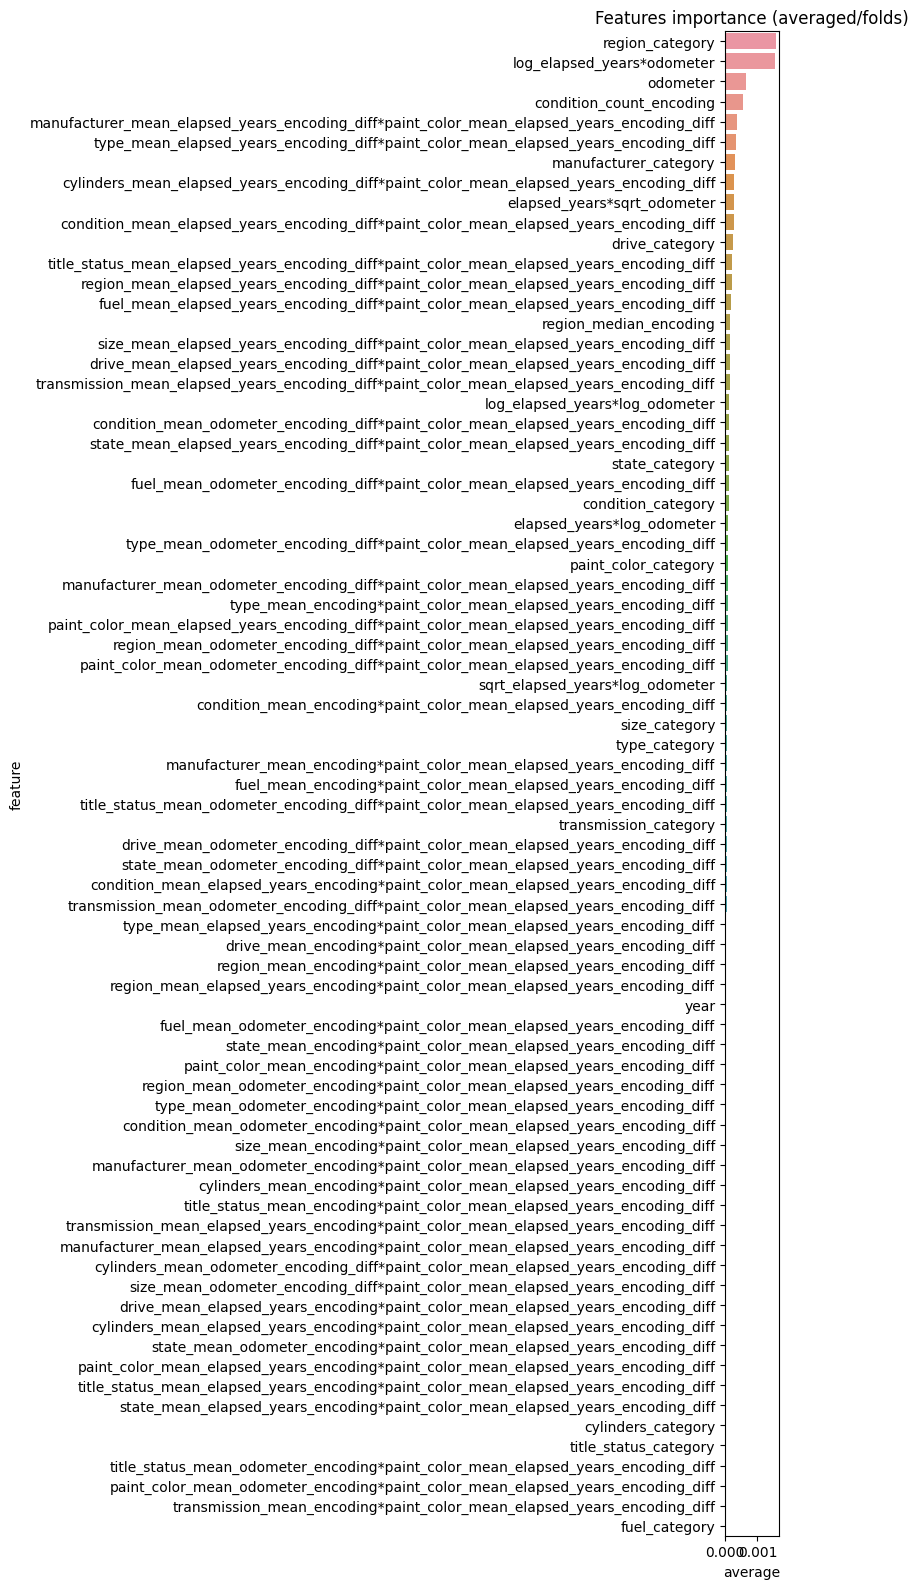

In [ ]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(75)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()